<a href="https://www.kaggle.com/code/hwanchul/lending-club-prep-modeling?scriptVersionId=262949188" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 데이터 불러오기

In [1]:
!pip install -U scikit-learn imbalanced-learn

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from imblearn.pipeline import Pipeline as ImbPipeline 
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import optuna

from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
import kagglehub
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

# Download latest version
path = kagglehub.dataset_download("wordsforthewise/lending-club")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df1 = pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv', low_memory=False)
#df2 = pd.read_csv('/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv', low_memory=False)

print("--- df1's info ---")
df1.info()

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv
--- df1's info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


## 프로젝트 목표 
___
- 대출자의 부도 예측: 대출 상환에 실패할 (Default) 대출자를 사전에 예측하는 분류(Classification) 문제.

- 타겟 변수 정의
    - loan_status를 활용하여 label 변수 생성
    
        - 부도(Default) 그룹: Charged Off, Default, Late (31-120 days)
    
        - 정상(Non-Default) 그룹: Fully Paid, Current
    
        - In Grace Period는 아직 부도로 확정되지 않은 상태이므로, 분석 목적에 따라 정상 그룹에 포함하거나 제외할 수 있습니다.

# 분석데이터 만들기

## 데이터 필터링
___

In [4]:
# 대출승인날짜(issue_d)를 토대로 대출승인 년도(issue_year), 월(issue_month), 분기(issue_quarter) 정보 추출

df1.dropna(subset=['issue_d'], inplace=True) ## issue_d 결측 데이터 삭제 --> 33개

df1['issue_month'] = df1['issue_d'].str.split('-', expand=True)[0]
df1['issue_year'] = df1['issue_d'].str.split('-', expand=True)[1].astype(int)

def get_quarter(month):
    if month in ['Jan', 'Feb', 'Mar']:
        return 'Q1'
    elif month in ['Apr', 'May', 'Jun']:
        return 'Q2'
    elif month in ['Jul', 'Aug', 'Sep']:
        return 'Q3'
    else:
        return 'Q4'

quarter_order = ['Q1', 'Q2', 'Q3', 'Q4']
df1['issue_quarter'] = pd.Categorical(df1['issue_month'].apply(get_quarter), categories=quarter_order, ordered=True)

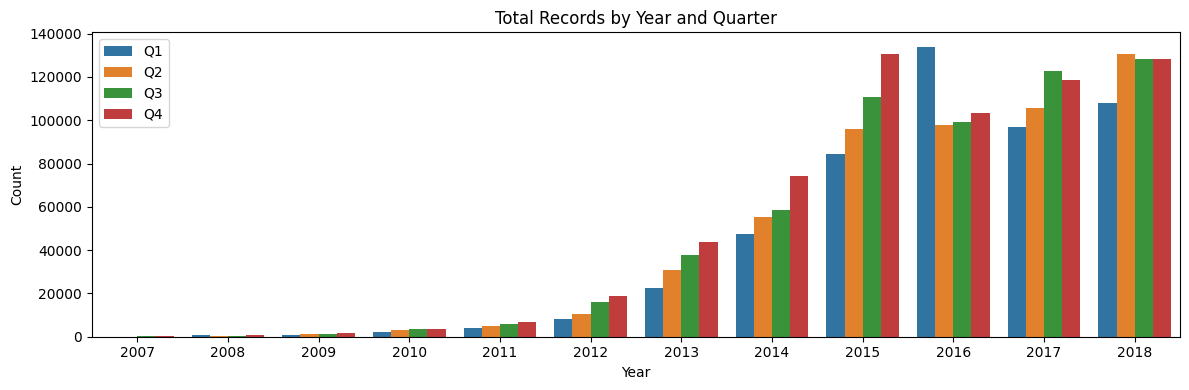

In [5]:
# 연도-분기별 총 레코드 수
total_records_by_quater = df1.groupby(['issue_year', 'issue_quarter'], observed=True)['issue_d'].count().sort_index()
total_records_by_quater.name = 'count'

# 연도-분기별 총 레코드 수 시각화
plt.figure(figsize=(12, 4))

sns.barplot(x='issue_year', y='count', hue='issue_quarter', data=total_records_by_quater.reset_index())
plt.title('Total Records by Year and Quarter')
plt.xlabel('Year'); plt.ylabel('Count')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 타겟 변수 정의
___

`loan_status`를 활용하여 `is_default` 변수 생성

- `True` (Default)
    - Charged Off: 대출 상환이 불가능하다고 판단되어 부도 처리된 상태입니다. 이는 회수 가능성이 낮아 손실로 기록된 경우입니다. 모델링에서는 주로 이 값을 '부도(Default)'로 정의합니다.
    
    - Default: 대출 상환 의무를 이행하지 못해 부도 상태에 빠진 경우입니다. Charged Off와 유사하지만, Lending Club의 내부 정책에 따라 부도 처리 전 단계로 분류될 수 있습니다.
    
    - Late (31-120 days): 대출 상환일로부터 31일에서 120일 사이로 연체된 상태입니다.
    
    - Late (16-30 days): 상환일로부터 16일에서 30일 사이로 연체된 상태입니다.

- `False` (NonDefault)
    - Fully Paid: 대출자가 모든 원금과 이자를 전액 상환하여 대출 계약이 완료된 상태입니다. 이는 대출 상환에 성공한 사례로 분류됩니다.
    
    - Current: 대출자가 현재 상환 기한을 잘 지키고 있는 상태입니다. 이 대출들은 아직 계약이 끝나지 않았으며, 현재로서는 부도 위험이 없는 것으로 간주됩니다.

In [6]:
def create_label(x):
    if x in ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default']:
        return True
        
    elif x in ['Fully Paid', 'Current']:
        return False
        
    return None 

df1['is_default'] = df1['loan_status'].apply(create_label).astype(bool)
df1 = df1.dropna(subset=['is_default'])

In [7]:
df1['is_default'].value_counts(normalize=True)

is_default
False    0.869766
True     0.130234
Name: proportion, dtype: float64

연도별 is_default 분포

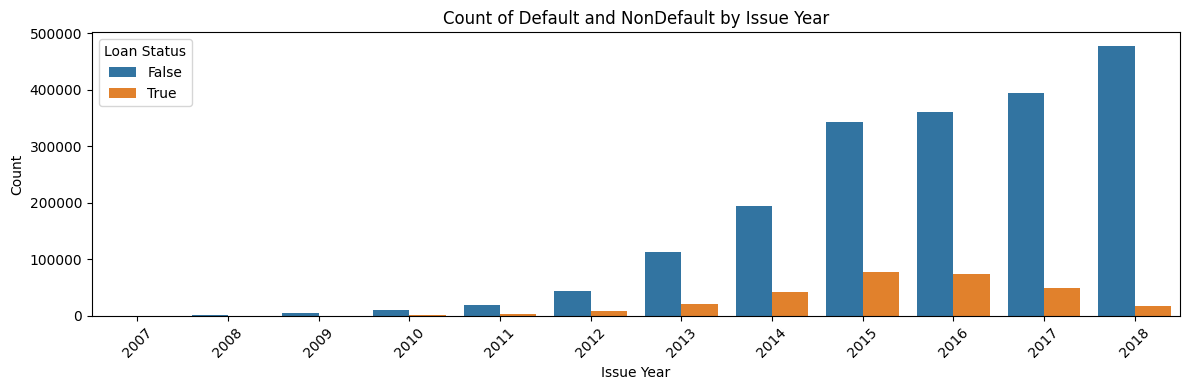

In [8]:
plt.figure(figsize=(12, 4))

sns.countplot(x='issue_year', hue='is_default', data=df1)
plt.title('Count of Default and NonDefault by Issue Year')
plt.xlabel('Issue Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan Status')
plt.tight_layout()
plt.show()

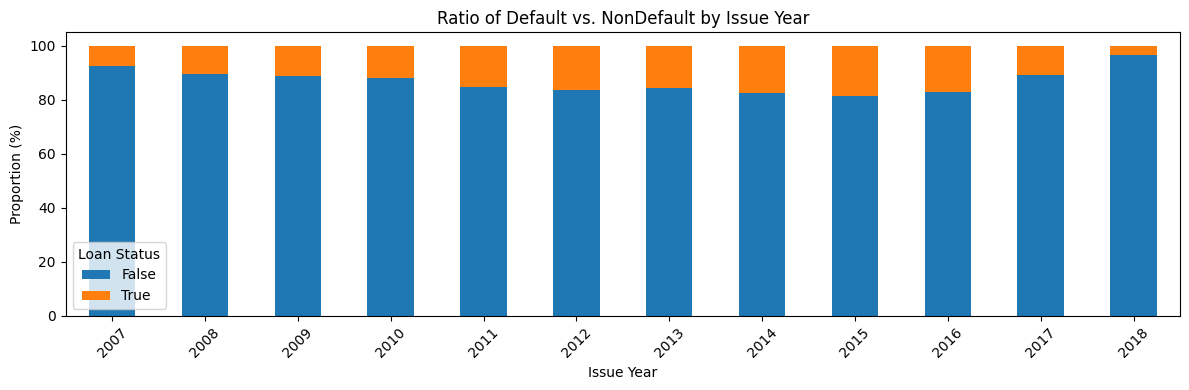

In [9]:
def plot_ratio_of_labels_by_year():
    df_grouped = df1.groupby(['issue_year', 'is_default']).size().unstack(fill_value=0)

    df_ratio = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
    
    df_ratio.plot(kind='bar', stacked=True, figsize=(12, 4))
    plt.title('Ratio of Default vs. NonDefault by Issue Year')
    plt.xlabel('Issue Year')
    plt.ylabel('Proportion (%)')
    plt.xticks(rotation=45)
    plt.legend(title='Loan Status')
    plt.tight_layout()
    plt.show()
    
plot_ratio_of_labels_by_year()

데이터 필터링 기준 및 이유
___
분석데이터를 `2015`년 이후 데이터만 활용 후 추후 확장 고려

In [10]:
df1 = df1[df1['issue_year'] == 2015]

## 데이터 누출 의심 특징, 불필요한 특징 처리

데이터 누수 의심 특징들 
___
대출(상환) 상태 관련  
-  `loan_status`: 대출 상태 (삭제 처리- target variance 생성에 활용됨)
- `total_rec_prncp`, `total_pymnt`, `total_pymnt_inv` : 총 대출금 상환 관련
- `recoveries`, `collection_recovery_fee`: 부도 상태(Charged off) 이후 발생하는 정보
- `debt_settlement_flag` , `hardship_flag`: 특별상환 계획 진행 관련
- `last_pymnt_amnt`, `last_pymnt_d`: 최근 상환 관련 금액, 일자  

잔여 원금 및 신용점수 관련  
- `last_fico_range_high`, `last_fico_range_low`: 최근 FICO 신용점수 high/low
- `out_prncp_inv`, `out_prncp`: 남은 원금 




불필요한 특징
___
- `id`, `member_id`, `url`

In [11]:
# 데이터 누수 특징
features_data_leakage_related = [
    'loan_status',
    'total_rec_prncp', 'total_pymnt', 'total_pymnt_inv', 
    'recoveries', 'collection_recovery_fee',
    'debt_settlement_flag', 'hardship_flag',
    'last_pymnt_amnt', 'last_pymnt_d',
    'last_fico_range_high', 'last_fico_range_low',  
    'out_prncp_inv', 'out_prncp', 
]
# 불필요한 특징
features_serial_info = [ 'id', 'member_id', 'url']

df1 = df1.drop(features_data_leakage_related + features_serial_info, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421095 entries, 0 to 421094
Columns: 138 entries, loan_amnt to is_default
dtypes: bool(1), category(1), float64(102), int64(1), object(33)
memory usage: 440.9+ MB


## 결측치 처리
___

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_missing_counts_by_columns(df):
    '''
    컬럼별 결측치 숫자 및 비율 시각화 및 반환 함수
    '''

    # 컬럼별 결측치 숫자 및 비율 정보 추출
    tmp = df.isnull().sum() 
    tmp_ratio = (tmp / len(df)) * 100
    missing_info = pd.DataFrame({'Missing_Count': tmp, 'Missing_Ratio': tmp_ratio})
    missing_info = missing_info[missing_info['Missing_Count'] != 0].sort_values(by='Missing_Count')
    
    # 시각화 
    height = 5 + len(missing_info) // 10
    
    plt.figure(figsize=(20, height))
    ax = missing_info['Missing_Count'].plot(kind='barh')
    
    for p in ax.patches:
        ax.annotate(str(int(p.get_width())), (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                    ha='left', va='center')
                    
    plt.title('Column Missing Values')
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Columns')
    plt.tight_layout()
    plt.show()

    return missing_info

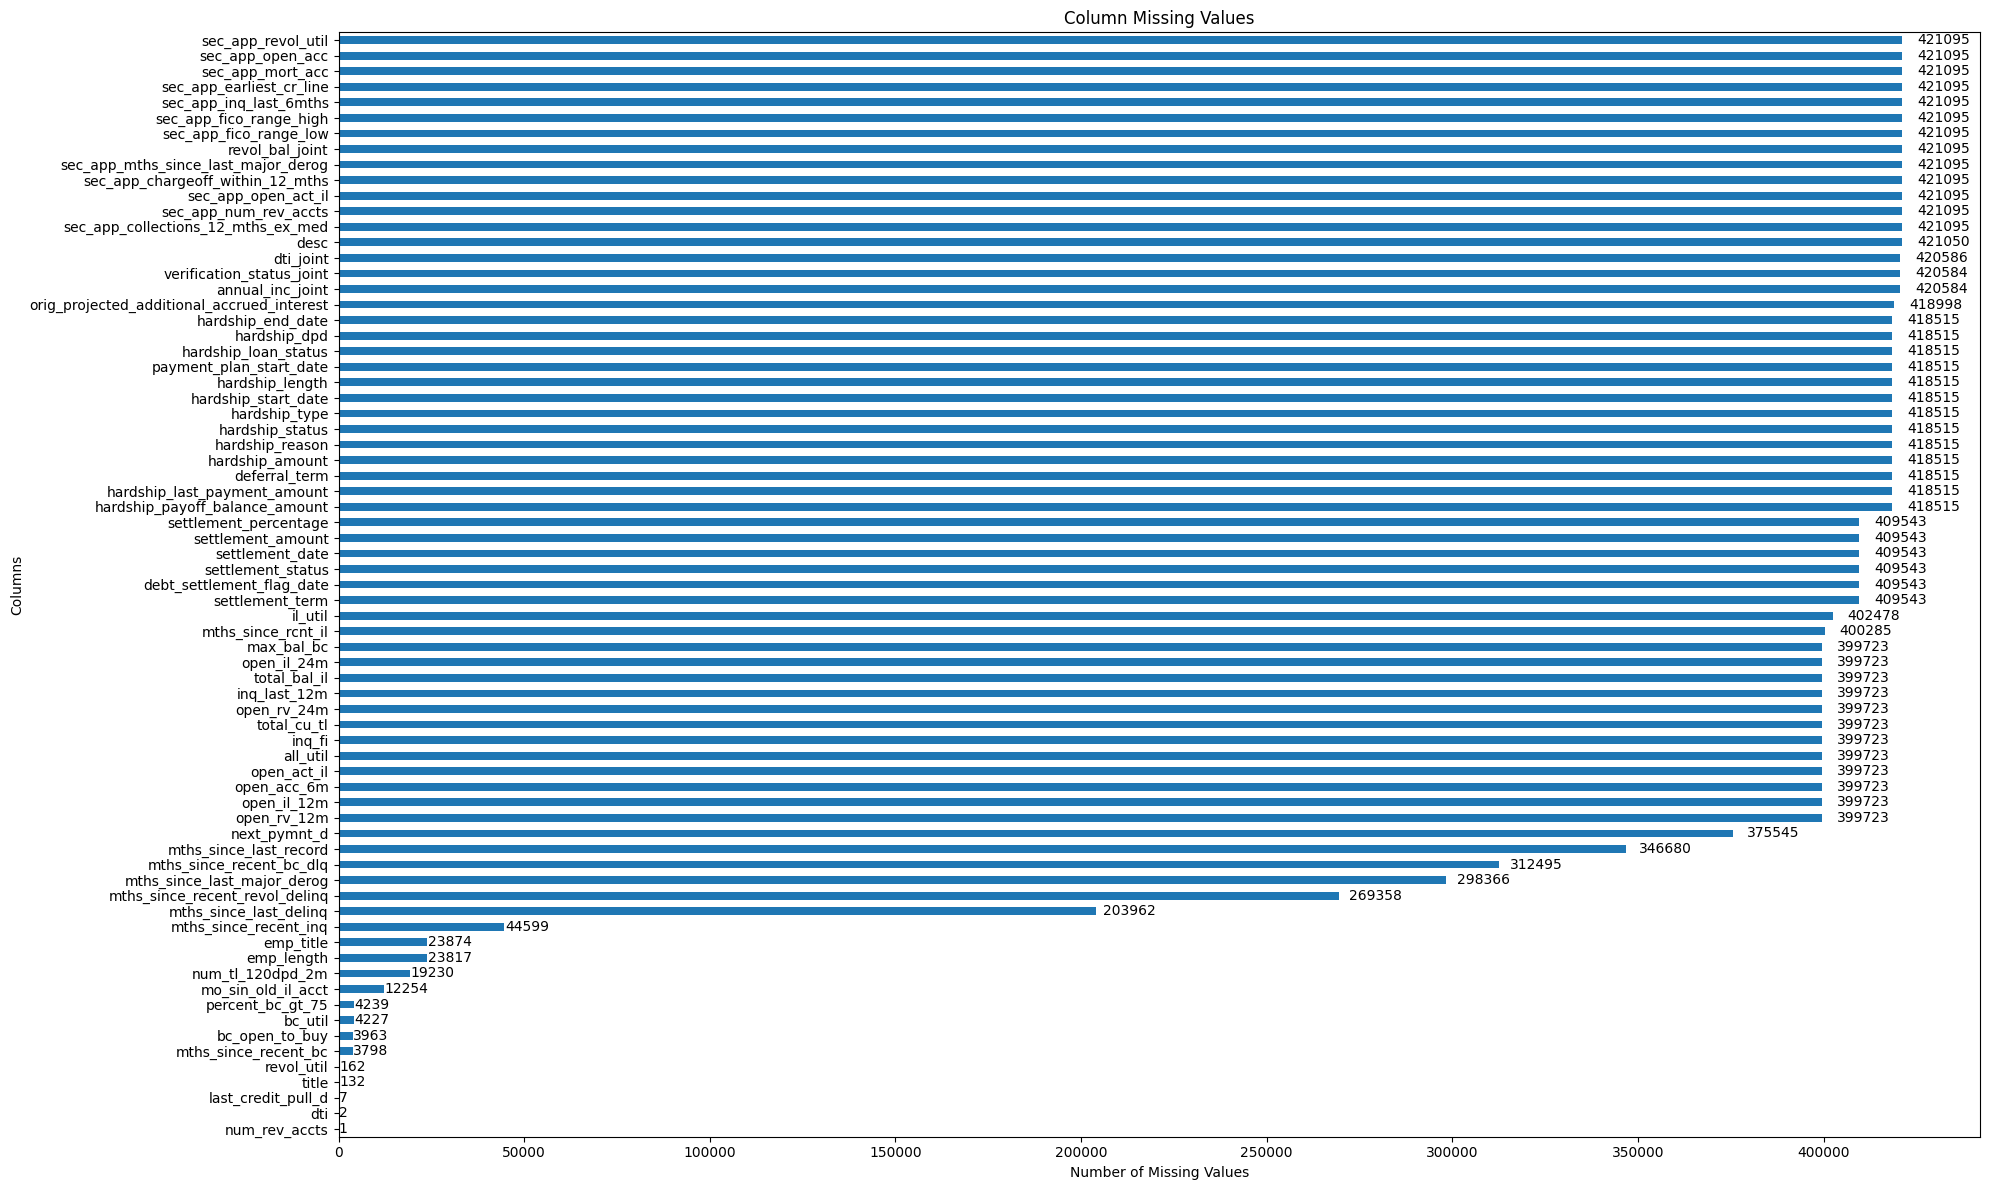

In [13]:
missing_counts_df1 = plot_missing_counts_by_columns(df1)

결측 비율 40% 초과 컬럼 정보 요약 
___
- 공동 대출 신청자 관련 컬럼 (4개)
- 2차 신청자 관련 컬럼 (12개)
- 채무 조정 및 부도 관련 컬럼 (20개)
- 신용 조회 및 계좌 관련 컬럼 (14개)
- 기타 대출 정보 (7개)


In [14]:
# 결측 비율 40% 초과 컬럼 정보
print(missing_counts_df1[missing_counts_df1['Missing_Ratio'] >= 40])
missing_counts_df1[missing_counts_df1['Missing_Ratio'] >= 40].shape

                                            Missing_Count  Missing_Ratio
mths_since_last_delinq                             203962      48.436101
mths_since_recent_revol_delinq                     269358      63.966088
mths_since_last_major_derog                        298366      70.854795
mths_since_recent_bc_dlq                           312495      74.210095
mths_since_last_record                             346680      82.328216
next_pymnt_d                                       375545      89.182963
open_rv_12m                                        399723      94.924661
open_il_12m                                        399723      94.924661
open_acc_6m                                        399723      94.924661
open_act_il                                        399723      94.924661
all_util                                           399723      94.924661
inq_fi                                             399723      94.924661
total_cu_tl                                        

(57, 2)

공동 대출 신청자 관련 컬럼  
- annual_inc_joint: 공동 신청 시 연간 소득
- dti_joint: 공동 신청 시 부채-소득 비율
- verification_status_joint: 공동 신청 시 소득 확인 상태
- revol_bal_joint: 공동 신청 시 회전식 신용 잔고

In [15]:
joint_related_columns = [col for col in missing_counts_df1.index if 'joint' in col]
display(missing_counts_df1.loc[joint_related_columns])

missing_counts_df1 = missing_counts_df1.drop(joint_related_columns)
df1 = df1.drop(joint_related_columns, axis=1)

,Missing_Count,Missing_Ratio
annual_inc_joint,420584,99.878650
verification_status_joint,420584,99.878650
dti_joint,420586,99.879125
revol_bal_joint,421095,100.000000


2차 신청자 관련 컬럼

- sec_app_collections_12_mths_ex_med: 2차 신청자의 12개월 내 의료 제외 채권 추심 기록
- sec_app_chargeoff_within_12_mths: 2차 신청자의 12개월 내 부도 처리 기록
- sec_app_num_rev_accts: 2차 신청자의 신용 계좌 수
- sec_app_open_act_il: 2차 신청자의 할부 계좌 수
- sec_app_open_acc: 2차 신청자의 개설된 총 계좌 수
- sec_app_inq_last_6mths: 2차 신청자의 최근 6개월 내 신용 조회 수
- sec_app_mort_acc: 2차 신청자의 모기지 계좌 수
- sec_app_fico_range_high / low: 2차 신청자의 FICO 신용 점수
- sec_app_earliest_cr_line: 2차 신청자의 가장 오래된 신용 거래 기록
- sec_app_revol_util: 2차 신청자의 신용 한도 사용률
- sec_app_mths_since_last_major_derog: 2차 신청자의 마지막 주요 채무 불이행 후 경과 개월 수

In [16]:
sec_app_related_columns = [col for col in missing_counts_df1.index if 'sec_app' in col]

display(missing_counts_df1.loc[sec_app_related_columns])
missing_counts_df1.loc[sec_app_related_columns].shape

missing_counts_df1 = missing_counts_df1.drop(sec_app_related_columns)
df1 = df1.drop(sec_app_related_columns, axis=1)

,Missing_Count,Missing_Ratio
sec_app_collections_12_mths_ex_med,421095,100.0
sec_app_num_rev_accts,421095,100.0
sec_app_open_act_il,421095,100.0
sec_app_chargeoff_within_12_mths,421095,100.0
sec_app_mths_since_last_major_derog,421095,100.0
sec_app_fico_range_low,421095,100.0
sec_app_fico_range_high,421095,100.0
sec_app_inq_last_6mths,421095,100.0
sec_app_earliest_cr_line,421095,100.0
sec_app_mort_acc,421095,100.0


채무 조정 및 부도 관련 컬럼 (20개)

- settlement_amount: 채무 조정 금액
- settlement_status: 채무 조정 상태
- settlement_date: 채무 조정일
- debt_settlement_flag_date: 채무 조정 플래그 설정일
- settlement_term: 채무 조정 기간
- settlement_percentage: 채무 조정된 금액의 비율
- hardship_status: 재정적 어려움 상태
- hardship_reason: 재정적 어려움 사유
- deferral_term: 상환 유예 기간
- hardship_amount: 재정적 어려움 지원 금액
- hardship_start_date / end_date: 재정적 어려움 시작/종료일
- hardship_type: 재정적 어려움 유형
- hardship_length: 재정적 어려움 기간
- hardship_last_payment_amount: 재정적 어려움 프로그램 내 마지막 상환액
- hardship_payoff_balance_amount: 재정적 어려움 프로그램 내 완납 잔액
- hardship_loan_status: 재정적 어려움 프로그램 내 대출 상태
- hardship_dpd: 재정적 어려움 프로그램 내 연체일 수
- payment_plan_start_date: 상환 계획 시작일입니다.
- deferral_term: 상환 유예 기간입니다.
- orig_projected_additional_accrued_interest: 재정적 어려움 프로그램으로 인해 발생한 추가 이자

In [17]:
settlement_related_columns = [col for col in missing_counts_df1.index if 'settlement' in col]
hardship_related_columns = [col for col in missing_counts_df1.index if 'hardship' in col] \
                         + ['orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'deferral_term']

display(missing_counts_df1.loc[settlement_related_columns + hardship_related_columns])
missing_counts_df1.loc[settlement_related_columns + hardship_related_columns].shape

missing_counts_df1 = missing_counts_df1.drop(settlement_related_columns + hardship_related_columns)
df1 = df1.drop(settlement_related_columns + hardship_related_columns, axis=1)

,Missing_Count,Missing_Ratio
settlement_term,409543,97.256676
debt_settlement_flag_date,409543,97.256676
settlement_status,409543,97.256676
settlement_date,409543,97.256676
settlement_amount,409543,97.256676
settlement_percentage,409543,97.256676
hardship_payoff_balance_amount,418515,99.387312
hardship_last_payment_amount,418515,99.387312
hardship_amount,418515,99.387312
hardship_reason,418515,99.387312


신용 조회 및 계좌 관련 컬럼 (14개)

- inq_last_12m: 최근 12개월간 신용 조회 건수.
- inq_fi: 최근 융자(mortgage/revolving 제외) 관련 조회 건수.
- open_rv_12m: 최근 12개월간 신규 회전식 계좌(신용카드 등) 개설 수.
- open_rv_24m: 최근 24개월간 신규 회전식 계좌 개설 수.
- open_il_12m: 최근 12개월간 신규 할부 계좌 개설 수.
- open_il_24m: 최근 24개월간 신규 할부 계좌 개설 수.
- open_acc_6m: 최근 6개월간 신규 신용 계좌 개설 수.
- open_act_il: 현재 개설된 할부 계좌 수.
- total_cu_tl: 신용 조합(credit union) 계좌 총 개수.
- total_bal_il: 할부 계좌(차량, 학자금 대출 등)의 총 잔액.
- mths_since_rcnt_il: 최근 할부 계좌 개설 후 경과 개월 수.
- il_util: 할부 계좌의 총 신용한도 사용률.
- all_util: 모든 신용 계좌의 총 신용한도 사용률.
- max_bal_bc: 신용카드 계좌의 최대 잔액.

In [18]:
keywords_to_filter = ['inq_', 'open_rv', 'open_il', 'open_ac', 'total_', 'il_util', 'all_util', 'max_bal_bc', 'mths_since_rcnt_il']

credit_inquiry_related_columns = [col for col in missing_counts_df1.index if any(keyword in col for keyword in keywords_to_filter)]

display(missing_counts_df1.loc[credit_inquiry_related_columns])
missing_counts_df1.loc[credit_inquiry_related_columns].shape

missing_counts_df1 = missing_counts_df1.drop(credit_inquiry_related_columns)
df1 = df1.drop(credit_inquiry_related_columns, axis=1)

,Missing_Count,Missing_Ratio
open_rv_12m,399723,94.924661
open_il_12m,399723,94.924661
open_acc_6m,399723,94.924661
open_act_il,399723,94.924661
all_util,399723,94.924661
inq_fi,399723,94.924661
total_cu_tl,399723,94.924661
open_rv_24m,399723,94.924661
inq_last_12m,399723,94.924661
total_bal_il,399723,94.924661


기타 대출 정보 (7개)  
- next_pymnt_d: 다음 상환일.
- mths_since_last_delinq: 마지막 연체 후 경과 개월 수.
- mths_since_recent_revol_delinq: 최근 리볼빙 계좌 연체 후 경과 개월 수.
- mths_since_last_major_derog: 마지막 주요 채무 불이행 후 경과 개월 수.
- mths_since_recent_bc_dlq: 최근 신용카드 연체 후 경과 개월 수.
- mths_since_last_record: 마지막 공개 기록(파산 등) 후 경과 개월 수.
- desc: 대출 신청자가 작성한 대출 설명


In [19]:
keywords_to_filter = ['next_pymnt_d', 'mths_since_la', 
                      'mths_since_recent_revol_delinq', 'mths_since_recent_bc_dlq', 'mths_since_last_record', 'desc']
                      
etc_features = [col for col in missing_counts_df1.index if any(keyword in col for keyword in keywords_to_filter)]

display(missing_counts_df1.loc[etc_features])
missing_counts_df1 = missing_counts_df1.drop(etc_features)

,Missing_Count,Missing_Ratio
mths_since_last_delinq,203962,48.436101
mths_since_recent_revol_delinq,269358,63.966088
mths_since_last_major_derog,298366,70.854795
mths_since_recent_bc_dlq,312495,74.210095
mths_since_last_record,346680,82.328216
next_pymnt_d,375545,89.182963
desc,421050,99.989314


In [20]:
df1['next_pymnt_d'].str.split('-', expand=True)[1].value_counts() # next_pymnt_d

1
2019    45545
2018        5
Name: count, dtype: int64

- 결측 비율이 89%인데다가 불균형이 심한 특징이라 활용하기 어려워 보임

In [21]:
# 연체 기록이 없는 경우
df1['mths_since_last_delinq'] = df1['mths_since_last_delinq'].fillna(-1) 
df1['mths_since_recent_revol_delinq'] = df1['mths_since_recent_revol_delinq'].fillna(-1) 
df1['mths_since_last_major_derog'] = df1['mths_since_last_major_derog'].fillna(-1)
df1['mths_since_recent_bc_dlq'] = df1['mths_since_recent_bc_dlq'].fillna(-1)
df1['mths_since_last_record'] = df1['mths_since_last_record'].fillna(-1)

df1 = df1.drop(['next_pymnt_d', 'desc'], axis=1) # 활용 불가능

결측 비율 4% 초과 컬럼

- mths_since_recent_inq: 최근 신용 조회(새로운 신용 신청 이력(예, 대출 신청, 카드 신청 등)이 있을 때 발생) 후 경과 개월 수.
- emp_title: 직업명.
- emp_length: 현 직장 근무 기간.
- num_tl_120dpd_2m: 최근 2년간 120일 이상 연체된 계좌 수.

In [22]:
keywords_to_filter = ['num_tl_120dpd_2m', 'mths_since_recent_inq', 'emp_title', 'emp_length']

missing_above_4p = [col for col in missing_counts_df1.index if any(keyword in col for keyword in keywords_to_filter)]

display(missing_counts_df1.loc[missing_above_4p])

missing_counts_df1 = missing_counts_df1.drop(missing_above_4p)
df1['mths_since_recent_inq'] = df1['mths_since_recent_inq'].fillna(-1) # 새로운 신용 신청 이력이 없는 경우로 판단
df1['num_tl_120dpd_2m'] = df1['num_tl_120dpd_2m'].fillna(0) # 연체 이력이 없는 케이스로 판단
df1['emp_title'] = df1['emp_title'].fillna('None') # 직업이 없는 케이스로 판단
df1['emp_length'] = df1['emp_length'].fillna(0) # 직업이 없는 케이스로 판단

,Missing_Count,Missing_Ratio
num_tl_120dpd_2m,19230,4.566665
emp_length,23817,5.655968
emp_title,23874,5.669505
mths_since_recent_inq,44599,10.591197


나머지 컬럼

- num_rev_accts: 리볼빙 계좌 수
- dti: 부채-소득 비율
- last_credit_pull_d: 마지막 신용 조회일
- title: 대출자가 기입한 대출 목적 제목
- revol_util: 리볼빙 계좌 신용 한도 사용률
- mths_since_recent_bc: 최근 신용카드 개설 후 경과 개월 수
- bc_open_to_buy: 신용카드 한도 대비 여유 금액
- bc_util: 신용카드 한도 사용률
- percent_bc_gt_75: 한도 75% 이상 사용 중인 신용카드 비율
- mo_sin_old_il_acct: 가장 오래된 할부 계좌 개설 후 경과 개월 수


In [23]:
display(missing_counts_df1)
missing_counts_df1.shape

df1['dti'] = df1['dti'].fillna(df1['dti'].median())
df1['title'] = df1['title'].fillna('None') # 대출 시 title 작성 안한 경우로 판단
df1['revol_util'] = df1['revol_util'].fillna(0) # 리볼빙 계좌가 없다고 판단

# 비율 
df1['bc_open_to_buy'] = df1['bc_open_to_buy'].fillna(0)
df1['bc_util'] = df1['bc_util'].fillna(0) 
df1['percent_bc_gt_75'] = df1['percent_bc_gt_75'].fillna(0)

# 경과 개월 수
df1['mths_since_recent_bc'] = df1['mths_since_recent_bc'].fillna(-1)
df1['mo_sin_old_il_acct'] = df1['mo_sin_old_il_acct'].fillna(-1)

# 결측 비율이 낮기 때문에 drop 처리
df1 = df1.dropna(subset=['num_rev_accts', 'last_credit_pull_d']) 

,Missing_Count,Missing_Ratio
num_rev_accts,1,0.000237
dti,2,0.000475
last_credit_pull_d,7,0.001662
title,132,0.031347
revol_util,162,0.038471
mths_since_recent_bc,3798,0.901934
bc_open_to_buy,3963,0.941118
bc_util,4227,1.003811
percent_bc_gt_75,4239,1.006661
mo_sin_old_il_acct,12254,2.910032


In [24]:
df1.isna().sum().sum()

0

In [25]:
df1.shape

(421087, 86)

## 범주형 특징 전처리

In [26]:
categorical_columns = df1.select_dtypes('object').columns 

summary_cat_features = {}
for col in categorical_columns:
  nuniq = df1[col].nunique()
  vals = df1[col].unique()
  summary_cat_features[col] = {'n_unique': nuniq, 'values': vals}

summary_cat_features = pd.DataFrame(summary_cat_features).T.sort_values('n_unique')
display(summary_cat_features)

,n_unique,values
disbursement_method,1,[Cash]
term,2,"[ 36 months, 60 months]"
application_type,2,"[Individual, Joint App]"
initial_list_status,2,"[w, f]"
pymnt_plan,2,"[n, y]"
verification_status,3,"[Not Verified, Source Verified, Verified]"
home_ownership,4,"[MORTGAGE, RENT, OWN, ANY]"
grade,7,"[C, B, F, A, E, D, G]"
issue_month,12,"[Dec, Nov, Oct, Sep, Aug, Jul, Jun, May, Apr, ..."
emp_length,12,"[10+ years, 3 years, 4 years, 6 years, 1 year,..."


disbursement_method, pymnt_plan

In [27]:
df1 = df1.drop('disbursement_method', axis=1) # nunique = 1
df1['pymnt_plan'] = df1['pymnt_plan'].map({'y':True, 'n':False}) # y/n -> boolean

emp_title
- 특수문자, 대소문자가 혼용되어 있어 자연어 전처리를 수행하였습니다.

In [28]:
def func_emp_title(df):
    df_copy = df.copy()

    df_copy['emp_title'] = df_copy['emp_title'].astype(str).str.lower()
    df_copy['emp_title'] = df_copy['emp_title'].str.replace(r'\t', '', regex=True)
    df_copy['emp_title'] = df_copy['emp_title'].str.replace(r'[^\w\s]', '', regex=True)
    df_copy['emp_title'] = df_copy['emp_title'].str.replace(r'\s+', ' ', regex=True)
    
    return df_copy

df1 = func_emp_title(df1)
print(df1['emp_title'].nunique())

99528


earliest_cr_line --> credit_history_mths (신용거래기간)
- 신용거래기간은 얼마나 오랫동안 신용을 관리해왔는지 알려주는 지표로 신용평가에 중요한 정보로 활용되고 있습니다.
- `earliest_cr_line` 특징은 nunique 가 688개로 인코딩 시 모델의 복잡도를 높여 학습이 비효율적이라고 판단하였습니다. 
- 이에, `issue_d`를 활용하여 신용거래기간 특징을 생성하였습니다.



In [29]:
def create_credit_history(df):
    df_copy = df.copy()
    
    df_copy['earliest_cr_line_dt'] = pd.to_datetime(df_copy['earliest_cr_line'], format='%b-%Y')
    df_copy['issue_d_dt'] = pd.to_datetime(df_copy['issue_d'], format='%b-%Y')
    
    # 신용거래기간
    df_copy['credit_history_mths'] = (
        (df_copy['issue_d_dt'].dt.year - df_copy['earliest_cr_line_dt'].dt.year) * 12 +
        (df_copy['issue_d_dt'].dt.month - df_copy['earliest_cr_line_dt'].dt.month))
    
    df_copy = df_copy.drop(['issue_d_dt', 'earliest_cr_line_dt', 'earliest_cr_line'], axis=1)
    
    return df_copy

df1 = create_credit_history(df1)
df1['credit_history_mths'].head(3)

0    148
1    192
2    184
Name: credit_history_mths, dtype: int32

last_credit_pull_d --> mths_since_last_credit_check (마지막 신용 조회 후 경과기간)

- issue_d와 last_credit_pull_d 정보를 활용하여 마지막 신용조회 후 경과기간 특징을 생성하였습니다.


In [30]:
def create_mths_since_last_credit_check(df):
    df_copy = df.copy()
    
    df_copy['issue_d_dt'] = pd.to_datetime(df_copy['issue_d'], format='%b-%Y')
    df_copy['last_credit_pull_d_dt'] = pd.to_datetime(df_copy['last_credit_pull_d'], format='%b-%Y')

    df_copy['mths_since_last_credit_check'] = (
        (df_copy['issue_d_dt'].dt.year - df_copy['last_credit_pull_d_dt'].dt.year) * 12 +
        (df_copy['issue_d_dt'].dt.month - df_copy['last_credit_pull_d_dt'].dt.month))
    
    df_copy['mths_since_last_credit_check'] = np.where(
        df_copy['mths_since_last_credit_check'] < 0, 0, df_copy['mths_since_last_credit_check'])
    
    df_copy = df_copy.drop(['last_credit_pull_d', 'issue_d_dt', 'last_credit_pull_d_dt'], axis=1)
    
    return df_copy

df1 = create_mths_since_last_credit_check(df1)
df1['mths_since_last_credit_check'].head(3)

0    0
1    0
2    0
Name: mths_since_last_credit_check, dtype: int32

※ 여기서 mths_since_recent_inq vs. time_since_last_credit_check의 차이
- mths_since_recent_inq (최근 신용 조회 후 경과 개월 수):
이 변수는 하드 인콰이어리(Hard Inquiry), 즉 대출이나 신용카드와 같이 새로운 신용을 신청한 시점을 기준으로 합니다. 하드 인콰이어리는 신용 점수에 영향을 미칠 수 있습니다. 짧은 기간에 여러 번 발생하면 재정적 어려움의 신호로 해석될 수 있습니다.

- mths_since_last_credit_check (마지막 신용 조회 후 경과 기간):
이 변수는 신용 풀(Credit Pull), 즉 하드 인콰이어리와 소프트 인콰이어리(Soft Inquiry)를 모두 포함합니다. 소프트 인콰이어리는 본인이 자신의 신용을 조회하거나, 광고성 목적의 신용 조회를 할 때 발생하며 신용 점수에 영향을 주지 않습니다.

grade, sub_grade

- sub_grade의 앞철자는 'A'부터 'G'까지, 뒤에 있는 숫자는 '1'부터 '5'의 값을 가집니다.
- 이를 순서대로 수치형으로 변환하였습니다. 예, 'A1'--> 35, 'A2'--> 34, ... , 'G5'--> 1

In [31]:
def transform_sub_grade(df):
    df_copy = df.copy()
    
    grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    sub_grades_ordered = [f'{g}{i}' for g in grades for i in range(1, 6)]
    
    sub_grade_map = {sub: len(sub_grades_ordered) - i for i, sub in enumerate(sub_grades_ordered)}
    
    df_copy['sub_grade'] = df_copy['sub_grade'].map(sub_grade_map)
    df_copy = df_copy.drop('grade', axis=1)

    return df_copy
    
df1 = transform_sub_grade(df1)
df1['sub_grade'].head(3)

0    22
1    25
2    27
Name: sub_grade, dtype: int64

emp_length

In [32]:
def func_emp_length_to_numeric(df):
    emp_length_mapping = {
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0.5,
        0: 0
    }
    df['emp_length'] = df['emp_length'].map(emp_length_mapping).astype(float)
    return df

df1 = func_emp_length_to_numeric(df1)

title
- 빈도수가 1인 값들은 Other로 변환하였습니다

In [33]:
def func_title(df):
  tmp = df['title'].value_counts()
  others = tmp[tmp<=1].index

  df['title'] = df['title'].replace(others, 'Other')
  return df

df1 = func_title(df1)

issue_d
- issue_d 를 unittime으로 변환하였습니다. 

In [34]:
def convert_to_unittime(df):
    df_copy = df.copy()

    df_copy['issue_d'] = pd.to_datetime(df_copy['issue_d'], format='%b-%Y')
    
    # 1970년 1월 1일 이후 경과된 일수로 변환
    df_copy['issue_d_days'] = (df_copy['issue_d'] - pd.Timestamp('1970-01-01')).dt.days
    
    # 원본 'issue_d'는 삭제
    df_copy = df_copy.drop('issue_d', axis=1)

    return df_copy

df1 = convert_to_unittime(df1)
df1['issue_d_days'].head(3)

0    16770
1    16770
2    16770
Name: issue_d_days, dtype: int64

범주형 특징 전처리 결과 확인

In [35]:
categorical_columns = df1.select_dtypes('object').columns 

summary_cat_features = {}
for col in categorical_columns:
  nuniq = df1[col].nunique()
  vals = df1[col].unique()
  summary_cat_features[col] = {'n_unique': nuniq, 'values': vals}

summary_cat_features = pd.DataFrame(summary_cat_features).T.sort_values('n_unique')
display(summary_cat_features)

,n_unique,values
term,2,"[ 36 months, 60 months]"
initial_list_status,2,"[w, f]"
application_type,2,"[Individual, Joint App]"
verification_status,3,"[Not Verified, Source Verified, Verified]"
home_ownership,4,"[MORTGAGE, RENT, OWN, ANY]"
issue_month,12,"[Dec, Nov, Oct, Sep, Aug, Jul, Jun, May, Apr, ..."
title,13,"[Debt consolidation, Business, None, Major pur..."
purpose,14,"[debt_consolidation, small_business, home_impr..."
addr_state,49,"[PA, SD, IL, NJ, GA, MN, SC, RI, TX, NC, CA, V..."
zip_code,914,"[190xx, 577xx, 605xx, 076xx, 174xx, 300xx, 550..."


In [36]:
df1[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 421087 entries, 0 to 421094
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   term                 421087 non-null  object
 1   emp_title            421087 non-null  object
 2   home_ownership       421087 non-null  object
 3   verification_status  421087 non-null  object
 4   purpose              421087 non-null  object
 5   title                421087 non-null  object
 6   zip_code             421087 non-null  object
 7   addr_state           421087 non-null  object
 8   initial_list_status  421087 non-null  object
 9   application_type     421087 non-null  object
 10  issue_month          421087 non-null  object
dtypes: object(11)
memory usage: 38.6+ MB


# 파이프라인 구축 및 모델 학습

데이터 분할

In [51]:
X = df1.drop('is_default', axis=1)
y = df1['is_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scale_pos_weight_value = y_train.value_counts()[False] / y_train.value_counts()[True]

전처리 파이프라인

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmpTitleTransformer(BaseEstimator, TransformerMixin):
    """
    EmpTitleTransformer
    
    입력받은 DataFrame의 emp_title과 annual_inc를 활용하여 emp_title_avg_inc (직업별 평균 연소득) 컬럼을 생성한 뒤 DataFrame을 return합니다.

    Args:
            DataFrame with 'emp_title', 'annual_inc' columns
    Returns:
            'emp_title_avg_inc'
    """
    
    def __init__(self):
        super().__init__()
        
        self.avg_inc_mapping = None
        self.global_avg = None

    def fit(self, X, y=None):
        self.avg_inc_mapping = X.groupby('emp_title')['annual_inc'].mean().to_dict() # 직업별 평균 소득 계산
        self.global_avg = X['annual_inc'].mean() # 전체 평균 소득 계산
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['emp_title_avg_inc'] = X_copy['emp_title'].map(self.avg_inc_mapping) # 학습된 매핑 정보를 사용해 변환
        X_copy['emp_title_avg_inc'] = X_copy['emp_title_avg_inc'].fillna(self.global_avg) # 데이터에 없는 직업은 학습 데이터의 전체 평균으로 채움
        
        #X_copy = X_copy.drop('emp_title', axis=1)
        
        return X_copy[['emp_title_avg_inc']]
    
class ZipCodeTransformer(BaseEstimator, TransformerMixin):
    """
    ZipCodeTransformer
    
    입력받은 DataFrame의 zip_code와 annual_inc를 활용하여 zip_code_avg_inc (거주지 우편번호별 평균 연소득) 컬럼을 생성한 뒤 DataFrame을 return합니다.
    `zip_code`와 같은 거주지 정보를 가진 addr_state는 삭제합니다. 
    
    Args:
            DataFrame with 'zip_code', 'annual_inc' and 'addr_state' columns
    Returns:
            'zip_code_avg_inc'
    """
    def __init__(self):
        super().__init__()
        self.avg_inc_mapping = None
        self.global_avg = None

    def fit(self, X, y=None):
        self.avg_inc_mapping = X.groupby('zip_code')['annual_inc'].mean().to_dict() # 직업별 평균 소득 계산
        self.global_avg = X['annual_inc'].mean() # 전체 평균 소득 계산
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['zip_code_avg_inc'] = X_copy['zip_code'].map(self.avg_inc_mapping) # 학습된 매핑 정보를 사용해 변환
        X_copy['zip_code_avg_inc'] = X_copy['zip_code_avg_inc'].fillna(self.global_avg) # 데이터에 없는 직업은 학습 데이터의 전체 평균으로 채움
        
        #X_copy = X_copy.drop(['zip_code', 'addr_state'], axis=1)
        
        return X_copy[['zip_code_avg_inc']]

class RatioFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    RatioFeatureTransformer
    
    입력받은 DataFrame의 loan_amnt, annual_inc, total_rev_hi_lim, 그리고 total_rec_late_fee를 활용하여 
    ratio_loan_income (대출금-연소득 비율), ratio_loan_rev_lim (대출금-신용한도 비율), ratio_latefee_loan_amnt (대출금-연체료 비율) 컬럼을 생성한 뒤 DataFrame을 return합니다.
    
    Args:
            DataFrame with 'loan_amnt', 'annual_inc', 'total_rev_hi_lim' and 'total_rec_late_fee' columns
    Returns:
            DataFrame with ratio_loan_income, ratio_loan_rev_lim, ratio_latefee_loan_amnt columns 
    """
    def __init__(self):
        super().__init__()
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # 대출금-연소득 비율
        X_copy['ratio_loan_income'] = X_copy['loan_amnt'] / X_copy['annual_inc']
        X_copy['ratio_loan_income'] = X_copy['ratio_loan_income'].replace([np.inf, -np.inf], 0) # 무한대 값 처리
        
        # 대출금-신용한도 비율
        X_copy['ratio_loan_rev_lim'] = X_copy['total_rev_hi_lim'] / X_copy['loan_amnt']
        
        # 대출금-연체료 비율
        X_copy['ratio_latefee_loan_amnt'] = X_copy['total_rec_late_fee'] / X_copy['loan_amnt']

        return X_copy[['ratio_loan_income', 'ratio_loan_rev_lim', 'ratio_latefee_loan_amnt']]

In [39]:
def create_full_pipeline(X_train_df, model, use_smote=False):
    """
    Creates a full preprocessing pipeline including custom and standard transformers.
    Args:
        X_train_df: The training feature DataFrame.
    Returns:
        A sklearn Pipeline object.
    """

    # 1. 모든 피처 리스트 정의
    custom_features_emp = ['emp_title', 'annual_inc']
    custom_features_zip = ['zip_code', 'annual_inc', 'addr_state']
    custom_features_ratio = ['loan_amnt', 'annual_inc', 'total_rev_hi_lim', 'total_rec_late_fee']

    categorical_features = X_train_df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = X_train_df.select_dtypes(include=np.number).columns.tolist()

    # 커스텀 변환기에서 사용되는 원본 컬럼을 제거하여 중복 처리 방지
    for col in custom_features_emp + custom_features_zip + custom_features_ratio:
        if col in categorical_features:
            categorical_features.remove(col)
        if col in numerical_features:
            numerical_features.remove(col)
            
    #features_to_scale = ['emp_title_avg_inc', 'zip_code_avg_inc', 'ratio_loan_income', 'ratio_loan_rev_lim', 'ratio_latefee_loan_amnt']

    # 로그 변환이 필요한 수치형 피처
    features_to_log_transform = [
        'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'revol_bal', 'total_acc', 'total_rec_int', 
        'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy']
    numerical_log_features = [f for f in numerical_features if f in features_to_log_transform]
    numerical_scale_only_features = [f for f in numerical_features if f not in features_to_log_transform]
    
    # 2. 모든 전처리를 포함하는 단일 ColumnTransformer 정의
    preprocessor   = ColumnTransformer(
        transformers=[
            # custom transformer
            ('emp_title_transformer', EmpTitleTransformer(), custom_features_emp),
            ('zip_code_transformer', ZipCodeTransformer(), custom_features_zip),
            ('ratio_feature_transformer', RatioFeatureTransformer(), custom_features_ratio),
            
            # numerical_log_features --> 로그 변환 + scaling 적용
            ('num_log', Pipeline([('log', FunctionTransformer(np.log1p)), ('scaler', StandardScaler())]), numerical_log_features),
            
            # numerical_scale_only_features --> scaling 적용
            ('num_scale', StandardScaler(), numerical_scale_only_features),
            
            # categorical_features --> onehot encoding 적용
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ], remainder='passthrough'
    )

    # 3. Combine custom and standard transformers in a single pipeline
    steps = [('preprocessor', preprocessor)]

    if use_smote:
        steps.append(('smote', SMOTE(random_state=42)))
    
    steps.append(('classifier', model))
    
    if use_smote:
        return ImbPipeline(steps=steps)
    else:
        return Pipeline(steps=steps)

모델학습 custom 함수

In [40]:
### Custom training 함수
def train_and_evaluate(model_pipeline, X_train, X_test, y_train, y_test):
    """
    Trains and evaluates a machine learning model.
    Args:
        model_pipeline: The model pipeline to train.
        X_train, X_test, y_train, y_test: The data splits.
    Returns:
        The trained model pipeline and a dictionary of metrics.
    """

    # 1. 모델 학습
    print("Training the model...")
    model_pipeline.fit(X_train, y_train)
    print("Training complete.")

    # 2. 예측 및 평가
    y_pred = model_pipeline.predict(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    model = model_pipeline.named_steps['classifier']
    if hasattr(model, 'predict_proba'):
        y_prob = model_pipeline.predict_proba(X_test)[:, 1]
        metrics['AUC'] = roc_auc_score(y_test, y_prob)

    return model_pipeline, metrics

## 모델 학습 및 평가

Holdout

In [41]:
import warnings
warnings.filterwarnings('ignore')

# Case 1 (No SMOTE, class weight in model)
print("--- Case 1 (No SMOTE, class weight in model) ---")
models = {"Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1),
          "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
          "XGBoost": xgb.XGBClassifier(use_label_encoder=False, random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight_value,
                                      tree_method='hist', device='cuda'),
          "LightGBM": lgb.LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42, n_jobs=-1, device='gpu',
                                       scale_pos_weight=scale_pos_weight_value)}


trained_pipelines = {}
for name, model in models.items():
    print(f"--- Training {name} ---")
    
    full_pipeline = create_full_pipeline(X_train, model, use_smote=False)
    pipeline, metrics = train_and_evaluate(full_pipeline, X_train, X_test, y_train, y_test)
    
    trained_pipelines[name] = {'pipeline': pipeline, 'metrics': metrics}


#  Case 2 (SMOTE, no class weight)
print("--- Case 2 (SMOTE, no class weight) ---")
models_without_class_weight = {"Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
          "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
          "XGBoost": xgb.XGBClassifier(use_label_encoder=False, random_state=42, n_jobs=-1, tree_method='hist', device='cuda'),
          "LightGBM": lgb.LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42, n_jobs=-1, device='gpu')}

trained_pipelines_with_SMOTE = {}
for name, model in models_without_class_weight.items():
    print(f"--- Training {name} ---")
    
    full_pipeline = create_full_pipeline(X_train, model, use_smote=True)
    pipeline, metrics = train_and_evaluate(full_pipeline, X_train, X_test, y_train, y_test)
    
    trained_pipelines_with_SMOTE[name] = {'pipeline': pipeline, 'metrics': metrics}
    

--- Case 1 (No SMOTE, class weight in model) ---
--- Training Logistic Regression ---
Training the model...
Training complete.

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.70      0.79     68730
        True       0.33      0.67      0.44     15488

    accuracy                           0.69     84218
   macro avg       0.62      0.68      0.61     84218
weighted avg       0.80      0.69      0.72     84218

--- Training Random Forest ---
Training the model...
Training complete.

Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.99      0.90     68730
        True       0.66      0.09      0.16     15488

    accuracy                           0.82     84218
   macro avg       0.75      0.54      0.53     84218
weighted avg       0.80      0.82      0.76     84218

--- Training XGBoost ---
Training the model...
Training complete.

Classification Report:
         

In [42]:
def summary_holdout_result(trained_pipelines):
    result = {}
    for model in trained_pipelines.keys():
        result[model] = trained_pipelines[model]['metrics']
    return pd.DataFrame(result)
    
c1_result = summary_holdout_result(trained_pipelines)
c2_result = summary_holdout_result(trained_pipelines_with_SMOTE)

print("--- Case 1 (No SMOTE, class weight in model) ---")
display(c1_result)
print("--- Case 2 (SMOTE, no class weight) ---")
display(c2_result)

--- Case 1 (No SMOTE, class weight in model) ---


,Logistic Regression,Random Forest,XGBoost,LightGBM
Accuracy,0.690802,0.824028,0.761619,0.757855
Precision,0.331233,0.662293,0.414339,0.410951
Recall,0.668582,0.088004,0.716426,0.730759
F1-Score,0.442995,0.155363,0.525031,0.526064
AUC,0.744455,0.773143,0.821280,0.821468


--- Case 2 (SMOTE, no class weight) ---


,Logistic Regression,Random Forest,XGBoost,LightGBM
Accuracy,0.679439,0.826332,0.835950,0.835344
Precision,0.320983,0.628965,0.614930,0.631853
Recall,0.666193,0.135718,0.288804,0.250775
F1-Score,0.433229,0.223261,0.393023,0.359048
AUC,0.736022,0.762746,0.818940,0.810871


`Case 1 (No SMOTE, class weight in model)` 과 `Case 2 (SMOTE, no class weight)` 비교

- `Case 1`은 `Case 2`에 비해 상대적으로 정확도와 정밀도가 낮지만 재현율과 F1-score가 높게 나왔습니다.
- 클래스 불균형을 가진 분류 문제이기 때문에 클래스 가중치를 사용한 `Case 1`을 활용하여 분석을 진행하는 것이 합리적이라고 판단합니다. 

### 교차검증

In [45]:
# cross_validate 함수를 사용하여 교차 검증 실행
cv_results = {}
for name, model in models.items():
    print(f"\n--- Cross Validation for {name} ---")

    full_pipeline = create_full_pipeline(X_train, model, use_smote=False)
    cv_results[name] = cross_validate(
        full_pipeline, X_train, y_train, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
        scoring= ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], n_jobs=-1) # XGBoost의 auc 계산 문제

    print(pd.DataFrame(cv_results[name]))


--- Cross Validation for Logistic Regression ---
     fit_time  score_time  test_accuracy  test_precision  test_recall  \
0  114.920147    1.294809       0.687387        0.327196     0.662631   
1  120.038204    1.222623       0.689955        0.330717     0.669922   
2  121.491315    0.629470       0.690296        0.331128     0.670567   
3  119.791589    1.243741       0.692374        0.331582     0.662174   
4   70.218405    0.590683       0.688481        0.329134     0.668362   

    test_f1  test_roc_auc  
0  0.438077      0.741887  
1  0.442826      0.742245  
2  0.443336      0.743738  
3  0.441889      0.744549  
4  0.441065      0.744490  

--- Cross Validation for Random Forest ---
     fit_time  score_time  test_accuracy  test_precision  test_recall  \
0  216.650232    7.302264       0.824279        0.675590     0.085553   
1  215.902344    7.258234       0.824606        0.686606     0.085223   
2  218.911016    6.137509       0.823508        0.677557     0.076991   
3  220.

In [48]:
def summary_cv_result(cv_results_df):
    mean_cv_results = {}
    for model_name, results in cv_results_df.items():
        mean_cv_results[model_name] = {metric: np.mean(scores) for metric, scores in results.items() if metric not in ['fit_time', 'score_time']}
        
    return pd.DataFrame(mean_cv_results).T
    
mean_cv_results = summary_cv_result(cv_results)
display(mean_cv_results)

,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
Logistic Regression,0.689698,0.329951,0.666731,0.441439,0.743382
Random Forest,0.824243,0.678757,0.084177,0.149743,0.772159
XGBoost,0.762816,0.415798,0.715220,0.525870,NaN
LightGBM,0.757300,0.410317,0.731264,0.525671,0.821937


- XGBoost 모델과 LightGBM 모델 외에는 타겟 변수를 잘 예측하지 못하는 것으로 확인하였습니다.
- 이에, 분류성능 향상을 위해 XGBoost 그리고 LightGBM에 대한 파라미터 튜닝을 진행하였습니다.

# 파라미터 튜닝

목적함수

In [53]:
import optuna

def objective(trial, model_type, X_train, y_train): # X_train, y_train을 인자로 추가
    if model_type == 'lgbm':
        param = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
            'random_state': 42,
            'n_jobs': -1,
            'scale_pos_weight': scale_pos_weight_value,
            'verbose': -1,
            'device': 'gpu'
        }
        model = lgb.LGBMClassifier(**param)
    elif model_type == 'xgb':
        param = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'lambda': trial.suggest_float('lambda', 0.0, 1.0),
            'alpha': trial.suggest_float('alpha', 0.0, 1.0),
            'random_state': 42,
            'n_jobs': -1,
            'scale_pos_weight': scale_pos_weight_value,
            'tree_method': 'gpu_hist'
        }
        model = xgb.XGBClassifier(**param)
    else:
        raise ValueError("Invalid model type")

    full_pipeline = create_full_pipeline(X_train, model, use_smote=False)
    
    scores = cross_validate(
        full_pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
        scoring='f1', n_jobs=-1)
    
    return np.mean(scores['test_score'])

In [ ]:
# LightGBM 튜닝
print("LightGBM 하이퍼파라미터 튜닝 시작...")
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(lambda trial: objective(trial, 'lgbm', X_train, y_train), n_trials=50, show_progress_bar=True)

print("\nBest parameters for LightGBM:")
print(study_lgbm.best_params)
print("Best F1-Score for LightGBM:")
print(study_lgbm.best_value)

[I 2025-09-20 08:17:11,192] A new study created in memory with name: no-name-f8495d77-f3ff-40b6-9366-ac9c4b923772


LightGBM 하이퍼파라미터 튜닝 시작...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-20 08:41:40,662] Trial 0 finished with value: 0.5279840949632599 and parameters: {'n_estimators': 552, 'learning_rate': 0.028954041101063394, 'num_leaves': 100, 'max_depth': 5, 'min_child_samples': 49, 'subsample': 0.7140224809167411, 'colsample_bytree': 0.8452209231293969, 'reg_alpha': 0.18783959417136176, 'reg_lambda': 0.8683928014664574}. Best is trial 0 with value: 0.5279840949632599.


In [ ]:
# XGBoost 튜닝
print("\nXGBoost 하이퍼파라미터 튜닝 시작...")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(lambda trial: objective(trial, 'xgb', X_train, y_train), n_trials=50, show_progress_bar=True)


print("\nBest parameters for XGBoost:")
print(study_xgb.best_params)
print("Best F1-Score for XGBoost:")
print(study_xgb.best_value)